# Lab | Comparing regression models

For this lab, we will be using the same dataset for the customer analysis case study we used in the previous labs. We recommend using the same notebook since you will be reusing the same variables you previous created and used in labs.

Instructions
1. Fit the models LinearRegression,Lasso and Ridge and compare the model performances. [Done]
2. Define a function that takes a list of models and trains (and tests) them so we can try a lot of them without repeating code.
3. Use feature selection techniques (P-Value, RFE) to select a subset of features to train the model with (if necessary).
4. (optional) Re-fit the models with the selected features.

In [157]:
#Importing libraries and data
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder


from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold # It only works with numerical features
from sklearn.linear_model import Lasso,Ridge,ElasticNet, LinearRegression, LassoCV, RidgeCV
from sklearn.feature_selection import RFE  ## recursive feature elemination technique
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('data/marketing_customer_analysis_clean (2).csv')
df = df.drop(columns = 'unnamed:_0')

# Separate the columns
categoricals_df = df.select_dtypes(include='object')
numericals_df = df.select_dtypes(include='number')





## Preprocessing

### Categorical

In [158]:
# Create new Dataframes splitt in nominal and ordinal
nominal_columns = ['state', 'response', 'employmentstatus', 'gender', 
                   'location_code', 'marital_status', 'policy_type', 
                   'sales_channel', 'policy','vehicle_class', 'vehicle_type', 'renew_offer_type']
nominal_df = categoricals_df[nominal_columns]

In [159]:
# Create new Dataframes splitt in nominal and ordinal
ordinal_columns = ['coverage','education', 'vehicle_size']
ordinal_df = categoricals_df[ordinal_columns]

In [160]:
# get_dummies with all the norminal columns
con_norminals_df = pd.get_dummies(nominal_df, dtype=int)

In [161]:
# For 'coverage' column
enc = OrdinalEncoder(categories=[['Basic', 'Extended', 'Premium']])
ordinal_df['coverage'] = enc.fit_transform(ordinal_df[['coverage']])

# For 'education' column
enc = OrdinalEncoder(categories=[['High School or Below', 'Bachelor', 'College', 'Master', 'Doctor']])
ordinal_df['education'] = enc.fit_transform(ordinal_df[['education']])

# For 'vehicle_size' column
enc = OrdinalEncoder(categories=[['Small', 'Medsize', 'Large']])
ordinal_df['vehicle_size'] = enc.fit_transform(ordinal_df[['vehicle_size']])

In [162]:
# Concat the two categorical Dataframes
result_categorical_df = pd.concat([ordinal_df, con_norminals_df], axis=1)

### Numerical

In [163]:
numericals_df

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
0,4809.216960,48029,61,7.000000,52,0.000000,9,292.800000,2
1,2228.525238,0,64,3.000000,26,0.000000,1,744.924331,1
2,14947.917300,22139,100,34.000000,31,0.000000,2,480.000000,2
3,22332.439460,49078,97,10.000000,3,0.000000,2,484.013411,1
4,9025.067525,23675,117,15.149071,31,0.384256,7,707.925645,1
...,...,...,...,...,...,...,...,...,...
10905,15563.369440,0,253,15.149071,40,0.384256,7,1214.400000,1
10906,5259.444853,61146,65,7.000000,68,0.000000,6,273.018929,1
10907,23893.304100,39837,201,11.000000,63,0.000000,2,381.306996,2
10908,11971.977650,64195,158,0.000000,27,4.000000,6,618.288849,2


In [164]:
# Drop NAN and duplicates
numericals_df = numericals_df.dropna()
numericals_df

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
0,4809.216960,48029,61,7.000000,52,0.000000,9,292.800000,2
1,2228.525238,0,64,3.000000,26,0.000000,1,744.924331,1
2,14947.917300,22139,100,34.000000,31,0.000000,2,480.000000,2
3,22332.439460,49078,97,10.000000,3,0.000000,2,484.013411,1
4,9025.067525,23675,117,15.149071,31,0.384256,7,707.925645,1
...,...,...,...,...,...,...,...,...,...
10905,15563.369440,0,253,15.149071,40,0.384256,7,1214.400000,1
10906,5259.444853,61146,65,7.000000,68,0.000000,6,273.018929,1
10907,23893.304100,39837,201,11.000000,63,0.000000,2,381.306996,2
10908,11971.977650,64195,158,0.000000,27,4.000000,6,618.288849,2


In [165]:
numericals_df = numericals_df.drop_duplicates()
numericals_df

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
0,4809.216960,48029,61,7.000000,52,0.000000,9,292.800000,2
1,2228.525238,0,64,3.000000,26,0.000000,1,744.924331,1
2,14947.917300,22139,100,34.000000,31,0.000000,2,480.000000,2
3,22332.439460,49078,97,10.000000,3,0.000000,2,484.013411,1
4,9025.067525,23675,117,15.149071,31,0.384256,7,707.925645,1
...,...,...,...,...,...,...,...,...,...
10904,19228.463620,0,187,14.000000,32,0.000000,2,897.600000,2
10905,15563.369440,0,253,15.149071,40,0.384256,7,1214.400000,1
10906,5259.444853,61146,65,7.000000,68,0.000000,6,273.018929,1
10907,23893.304100,39837,201,11.000000,63,0.000000,2,381.306996,2


### Concat both

In [166]:
final_df = pd.concat([result_categorical_df, numericals_df], axis=1)
final_df = final_df.drop(columns=['month'])

In [167]:
# Drop nan of target value
final_df['total_claim_amount'].isna().sum()

2303

In [168]:
final_df = final_df.dropna(subset=['total_claim_amount'])

## Splitting data

In [169]:
#define X and Y

X = final_df.drop(columns=['total_claim_amount'], axis = 1)
y = np.log(final_df['total_claim_amount'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


## Standardising Data

#### MinMax scaler for X

In [170]:
# MinMax X_train
mm = MinMaxScaler() # Initialize the PowerTransformer
mm.fit(X_train) # Fit to and transform X_train
X_train=mm.transform(X_train)
# MinMax X_test
X_test = mm.transform(X_test) # Transform X_test using the fitted transformer

#### Power Transform

In [171]:
#PowerTransform y_train
pt1 = PowerTransformer()
y_train = pd.DataFrame(y_train)
y_train = pt1.fit_transform(y_train)
#PowerTransform y_test
y_test = pd.DataFrame(y_test)
y_test = pt1.transform(y_test)

In [172]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_train

,coverage,education,vehicle_size,state_Arizona,state_California,state_Nevada,state_Oregon,state_Washington,response_No,response_Yes,...,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,0.0,0.50,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.104036,0.000000,0.033755,1.000000,0.505051,0.0,0.125
1,0.0,0.50,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.143212,0.980546,0.219409,0.514286,0.929293,0.0,0.125
2,0.5,0.75,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.063043,0.162271,0.135021,0.371429,0.555556,0.0,1.000
3,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.094754,0.344045,0.000000,0.285714,0.181818,0.2,0.125
4,1.0,0.00,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.082041,0.780918,0.194093,0.314286,0.474747,0.4,0.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6880,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.010913,0.943279,0.037975,0.028571,0.767677,0.8,0.000
6881,0.0,0.50,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.155872,0.462528,0.004219,0.228571,0.030303,0.0,0.125
6882,0.5,0.00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.094854,0.548824,0.253165,0.257143,0.505051,0.0,0.250
6883,0.0,0.00,0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.071434,0.000000,0.054852,0.942857,0.242424,0.0,0.125


## Variance threshold method

In [173]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

#display(X_train)
print("Initial number of numerical columns: ",X_train.shape)
print()

selector = VarianceThreshold() # Default threshold value is 0
# Features with a training-set variance lower than this threshold will be removed.
selector.fit(X_train)

kept_features_indexes = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features_indexes
kept_features = list(X_train.iloc[:,kept_features_indexes].columns)
kept_features

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)

X_train
print("Final number of numerical columns: ",X_train.shape)
print()
X_train


Initial number of numerical columns:  (6885, 57)

Final number of numerical columns:  (6885, 56)



,coverage,education,vehicle_size,state_Arizona,state_California,state_Nevada,state_Oregon,state_Washington,response_No,response_Yes,...,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,0.0,0.50,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.104036,0.000000,0.033755,1.000000,0.505051,0.0,0.125
1,0.0,0.50,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.143212,0.980546,0.219409,0.514286,0.929293,0.0,0.125
2,0.5,0.75,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.063043,0.162271,0.135021,0.371429,0.555556,0.0,1.000
3,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.094754,0.344045,0.000000,0.285714,0.181818,0.2,0.125
4,1.0,0.00,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.082041,0.780918,0.194093,0.314286,0.474747,0.4,0.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6880,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.010913,0.943279,0.037975,0.028571,0.767677,0.8,0.000
6881,0.0,0.50,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.155872,0.462528,0.004219,0.228571,0.030303,0.0,0.125
6882,0.5,0.00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.094854,0.548824,0.253165,0.257143,0.505051,0.0,0.250
6883,0.0,0.00,0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.071434,0.000000,0.054852,0.942857,0.242424,0.0,0.125


## Correlation matrix

['monthly_premium_auto', 'income', 'total_claim_amount']


,monthly_premium_auto,income,total_claim_amount
0,61,48029,292.800000
1,64,0,744.924331
2,100,22139,480.000000
3,97,49078,484.013411
4,117,23675,707.925645
...,...,...,...
10904,187,0,897.600000
10905,253,0,1214.400000
10906,65,61146,273.018929
10907,201,39837,381.306996


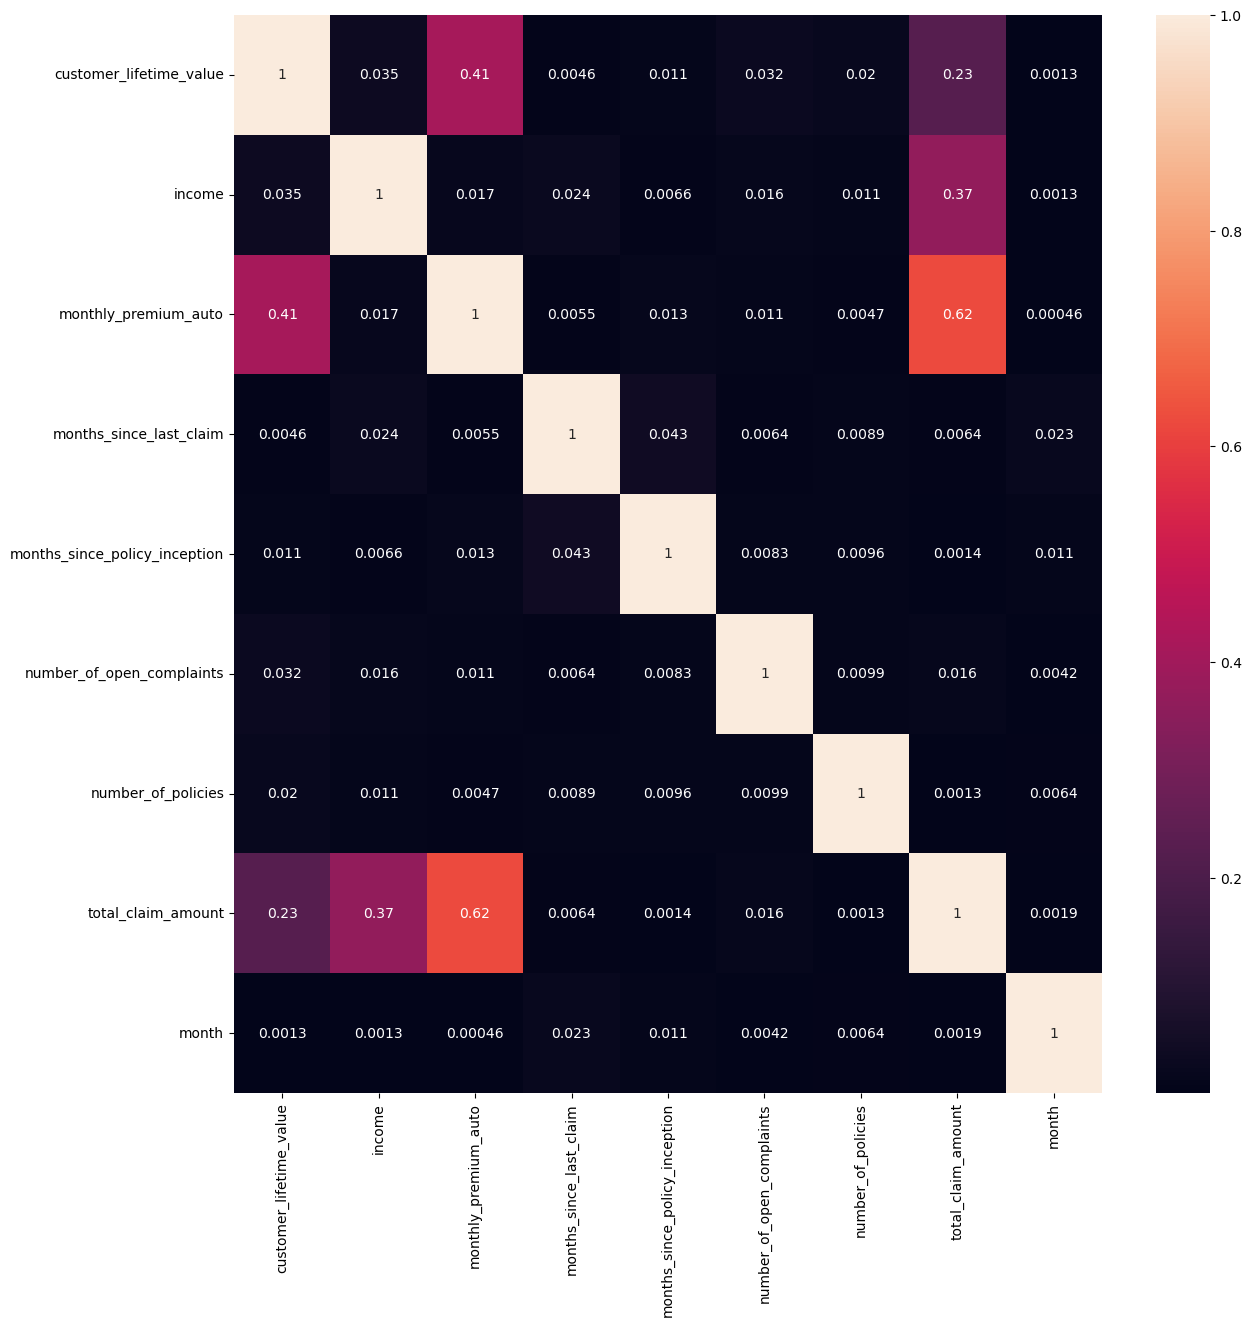

In [174]:
c = abs(numericals_df.corr())

fig, ax = plt.subplots(figsize=(14,14))

sns.heatmap(c, annot=True);


c_last = c["total_claim_amount"].sort_values(ascending=False)

#c_last
c_thr = .3
cols_to_keep = list(c_last[c_last > c_thr].index)[1:] + [list(c_last[c_last > c_thr].index)[0]]
print(cols_to_keep)
numericals_df[cols_to_keep]

In [175]:
numericals_df

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
0,4809.216960,48029,61,7.000000,52,0.000000,9,292.800000,2
1,2228.525238,0,64,3.000000,26,0.000000,1,744.924331,1
2,14947.917300,22139,100,34.000000,31,0.000000,2,480.000000,2
3,22332.439460,49078,97,10.000000,3,0.000000,2,484.013411,1
4,9025.067525,23675,117,15.149071,31,0.384256,7,707.925645,1
...,...,...,...,...,...,...,...,...,...
10904,19228.463620,0,187,14.000000,32,0.000000,2,897.600000,2
10905,15563.369440,0,253,15.149071,40,0.384256,7,1214.400000,1
10906,5259.444853,61146,65,7.000000,68,0.000000,6,273.018929,1
10907,23893.304100,39837,201,11.000000,63,0.000000,2,381.306996,2


## Models

### OLS

In [176]:
lm = LinearRegression()
model = lm.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

LinearRegression: Train -> 0.8421135802675662, Test -> 0.8371504134946298


### Lasso

In [177]:
model=Lasso(alpha=0.003)

model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

Lasso: Train -> 0.8406519153748798, Test -> 0.8391994361469868


### Ridge

In [178]:
model=Ridge(alpha=0)
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

Ridge: Train -> 0.8420263956623529, Test -> 0.8366636325555845


### EleasticNet

In [179]:
model=ElasticNet(alpha=0)
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

ElasticNet: Train -> 0.8425025426382984, Test -> 0.8369607764991294


### Lasso CV

In [180]:
model = LassoCV(alphas = np.logspace(-4,2,20) ,cv=10, max_iter=10000, n_jobs=-1)
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")
optimal_alpha = model.alpha_
print(f"The optimal alpha is: {optimal_alpha}")

LassoCV: Train -> 0.8423366820769026, Test -> 0.8376573813032056
The optimal alpha is: 0.00042813323987193956


### Ridge CV

In [181]:
alphas = np.logspace(-4,2,20)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")
optimal_alpha = ridge_cv.alpha_
print(f"The optimal alpha is: {optimal_alpha}")

LassoCV: Train -> 0.8423366820769026, Test -> 0.8376573813032056
The optimal alpha is: 0.0001


## Recursive feature elimination (RFE)
Use feature selection techniques (P-Value, RFE) to select a subset of features to train the model with (if necessary).

In [182]:
X_train_rfe, X_test_rfe, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train_rfe = X_train_rfe.select_dtypes(include=np.number)
X_test_rfe = X_test_rfe.select_dtypes(include=np.number)

X_train = pd.DataFrame(X_train_rfe, columns=X.columns)
X_test  = pd.DataFrame(X_test_rfe, columns=X.columns)

selector = RFE(lm, n_features_to_select= 2, step = 1, verbose = 1) # Step is how many features to add or drop everytime
selector.fit(X_train_rfe, y_train)

kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train_rfe.iloc[:,kept_features].columns)

X_train_rfe = selector.transform(X_train_rfe)
X_test_rfe  = selector.transform(X_test_rfe)

X_train_rfe = pd.DataFrame(X_train_rfe, columns=kept_features)
X_test_rfe  = pd.DataFrame(X_test_rfe, columns=kept_features)

print("Final selected features: ")
display(X_train_rfe)

Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 fe

,vehicle_class_Luxury Car,vehicle_class_Luxury SUV
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
6880,0.0,0.0
6881,0.0,0.0
6882,0.0,0.0
6883,0.0,0.0


### P values

In [183]:
def feature_selection_pvalue(X, y, significance_level=0.05):
    # Add a constant term (intercept) to the feature matrix X
    X = sm.add_constant(X)
    # Fit a linear regression model using Ordinary Least Squares
    model = sm.OLS(y, X).fit()
    # Extract p-values for each coefficient, excluding the constant term
    p_values = model.pvalues[1:]  # Exclude the constant term
     # Select features whose p-values are less than the specified significance level
    selected_features = X.columns[1:][p_values < significance_level]
    # Return the list of selected features
    return selected_features
# Use case:
selected_features_pvalue = feature_selection_pvalue(X, y)
# Print or display the selected features
print("Selected Features based on P-value:")
print(selected_features_pvalue)

Selected Features based on P-value:
Index(['vehicle_size', 'state_Arizona', 'state_California', 'state_Nevada',
       'state_Oregon', 'state_Washington', 'response_No', 'response_Yes',
       'employmentstatus_Disabled', 'employmentstatus_Employed',
       'employmentstatus_Medical Leave', 'employmentstatus_Retired',
       'employmentstatus_Unemployed', 'gender_F', 'gender_M',
       'location_code_Rural', 'location_code_Suburban', 'location_code_Urban',
       'marital_status_Divorced', 'marital_status_Married',
       'marital_status_Single', 'policy_type_Corporate Auto',
       'policy_type_Personal Auto', 'policy_type_Special Auto',
       'sales_channel_Agent', 'sales_channel_Branch',
       'sales_channel_Call Center', 'sales_channel_Web', 'policy_Corporate L1',
       'policy_Corporate L2', 'policy_Corporate L3', 'policy_Personal L1',
       'policy_Personal L2', 'policy_Personal L3', 'policy_Special L1',
       'policy_Special L2', 'policy_Special L3', 'vehicle_class_Four-Doo

## Multiple model evaluation function

In [184]:
#Define a function that takes a list of models and trains (and tests) them so we can try a lot of them without repeating code.

In [185]:
# List of models to train and evaluate
model_list = [LinearRegression(),Ridge(alpha=1.0),Lasso(alpha=0.1),ElasticNet(alpha=0),
              RFE(lm, n_features_to_select= 2, step = 1),
              RFE(lm, n_features_to_select= 3, step = 1),
              RFE(lm, n_features_to_select= 4, step = 1),
              RFE(lm, n_features_to_select= 5, step = 1),
              RFE(lm, n_features_to_select= 6, step = 1),
              RFE(lm, n_features_to_select= 7, step = 1),
              RFE(lm, n_features_to_select= 8, step = 1),
              ]
    
def multi_model_evaluation(model_list,X_train,y_train,X_test,y_test):
    for model in model_list:
        model.fit(X_train, y_train)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

In [187]:
multi_model_evaluation(model_list,X_train,y_train,X_test,y_test)

LinearRegression: Train -> 0.7373392324533621, Test -> 0.7393092274669446
Ridge: Train -> 0.7373389755661732, Test -> 0.7393237812846689
Lasso: Train -> 0.6416849479836975, Test -> 0.6467006175000095
ElasticNet: Train -> 0.7373392324533621, Test -> 0.739309227466932
RFE: Train -> 0.04631700941054162, Test -> 0.05166907794752962
RFE: Train -> 0.08951476919608958, Test -> 0.0791435266740751
RFE: Train -> 0.10219399905124849, Test -> 0.091825272147393
RFE: Train -> 0.10232371426265485, Test -> 0.09100978024656625
RFE: Train -> 0.10228524378474313, Test -> 0.09096102862300526
RFE: Train -> 0.1252662558838692, Test -> 0.13040734482113847
RFE: Train -> 0.14268122173046927, Test -> 0.14685136300249046
